  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Loading Data


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.72it/s]


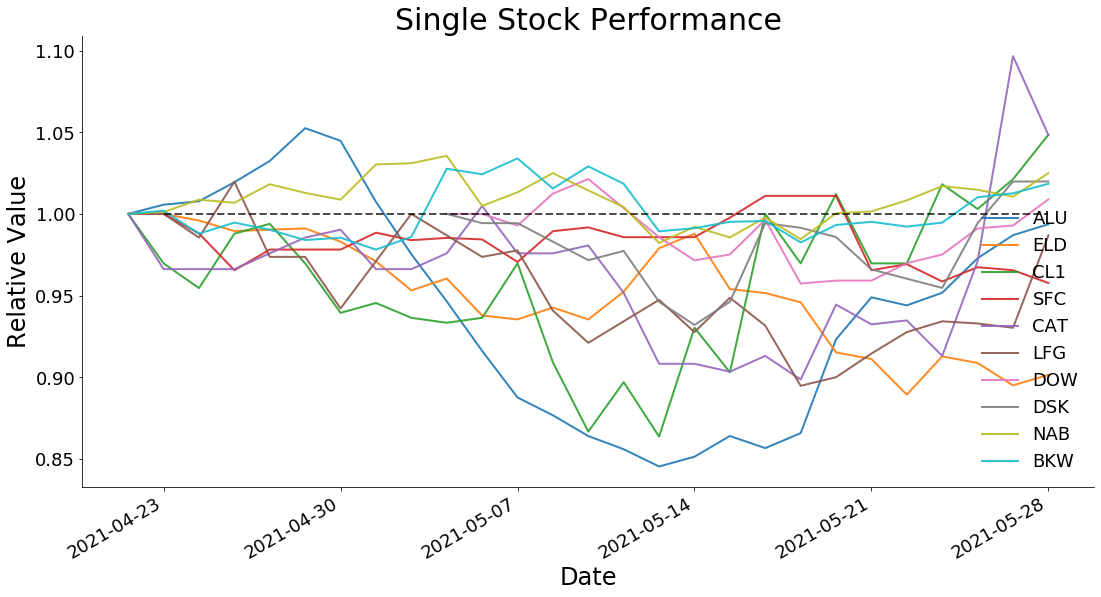

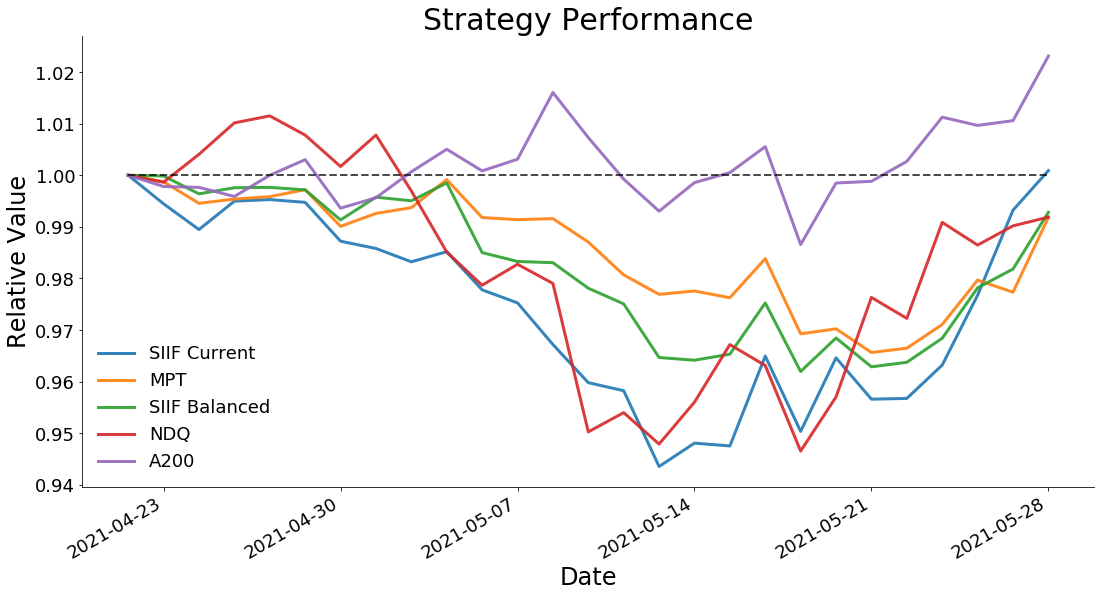

==== Begin emailing at 2021-05-29 00:20:51.249965 ====

Email to    Cameron succeeded at 2021-05-29 00:21:00.459002

==== Completed emailing at2021-05-29 00:21:00.459002 ====




In [1]:
############################################### TODO ################################################
# - Random Greetings etc.
# - Add Do Not Reply message (footnote?)
# - Add custom stocks to weekly report
# - Get script to run automatically
# - Check day of week and
#     - If Friday night send weekly report
#     - If Weekday send stock alerts based on movement triggers
# - Description of charts?
# - Move legend further to right to avoid collision

####################################### STEP 1. PREPARE DATA ########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from siif_utils import load_data, plot_shares, plot_comps, load_comps, get_cash, send_email, attach_file, attach_image
from siif_utils import TRADING_DAYS, INITIAL_CASH, UNITS, BUY_PRICE, BUY_DATE, SELL_DATE, SELL_PRICE, FEE, TOMORROW

# NEED TO CONFIRM WHEN STOCKS WERE BOUGHT
comps = load_comps(filenames=['SIIF', 'MPT', 'SIIF_MPT', 'NDQ', 'A200'], 
                   names=['SIIF Current', 'MPT', 'SIIF Balanced', 'NDQ', 'A200'])

# Get set of all stock codes
ALL_STOCKS = set(sum([list(data['comp'].keys()) for _, data in comps.items()], []))
daily = load_data(ALL_STOCKS, start='2021-04-23')

for comp_name, comp in comps.items():    
    # Add daily data
    comp['daily'] = daily[comp['comp'].keys()]
    
    # Place zeros where share was not held
    for i, code in enumerate(comp['daily']):
        buy_date, sell_date = comp['comp'][code][BUY_DATE], comp['comp'][code][SELL_DATE]
        comp['daily'].iloc[0:comp['daily'].index.to_list().index(pd.to_datetime(buy_date)), i] = 0
        if sell_date != TOMORROW:
            comp['daily'].iloc[comp['daily'].index.to_list().index(pd.to_datetime(sell_date)):, i] = 0
            
    units = np.array([comp['comp'][code][UNITS] for code in comp['daily']])
    comp['portfolio_value'] = comp['daily'].to_numpy() @ units + get_cash(comp)
    
######################################### STEP 2. PLOT DATA #########################################
plot_shares(comps['SIIF Current']['daily'], comps['SIIF Current']['comp'], save=True)
plot_comps(comps, save=True)

######################################## STEP 3. SEND EMAILS ########################################
# Stock Alert Report Automaton
# SIIF Automated Reporting Assistant
# - Sara

import cgi
import uuid
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.header import Header

TEST, PROD = 0, 1
RUNNING_LEVEL = TEST
TEST_NAME = 'Cameron'

def log(typ, name='', running_level=RUNNING_LEVEL, verbose=True):
    ''' Log the emailing process. Log to log.txt if running_level is PROD, print if verbose is True '''
    # What is the message
    if typ == 'begin':
        msg = '==== Begin emailing at ' + str(dt.datetime.now()) + ' ====\n'
    elif typ == 'success':
        msg = f'Email to {name.rjust(10)} succeeded at ' + str(dt.datetime.now()) + '\n'
    elif typ == 'failure':
        msg = f'Email to {name.rjust(10)} failed at ' + str(dt.datetime.now()) + '\n'
    elif typ == 'end':
        msg = '==== Completed emailing at ' + str(dt.datetime.now()) + ' ====\n\n'
    
    # Where to log
    if running_level == PROD:
        with open('log.txt', 'a') as f:
            f.write(msg)
    if verbose:
        print(msg)
        
# Load analyst emails
emails = pd.read_csv('./data/emails.csv')
ANALYSTS_TEST = emails[emails['name'] == TEST_NAME]
ANALYSTS_PROD = emails
ANALYSTS = ANALYSTS_PROD if RUNNING_LEVEL == PROD else ANALYSTS_TEST

gmail_user = "sarasiifbot@gmail.com"
with open('./data/password.txt') as f:
    gmail_pwd = f.read()

LOGO_PATH = './images/SIIF Logo.png'
LOGO_SCALE = (258, 155)
GRAPH_SCALE = (691, 389)

def generate_email(gmail_user, to, img_dict, name='Analyst'):
    msg = MIMEMultipart('related')
    msg['Subject'] = Header(u'SIIF Weekly Report', 'utf-8')
    msg['From'] = gmail_user
    msg['To'] = to
    msg_alternative = MIMEMultipart('alternative')
    msg_text = MIMEText(u'Image not working', 'plain', 'utf-8')
    msg_alternative.attach(msg_text)
    msg.attach(msg_alternative)

    msg_html = u'<p>Dear {},</p>'.format(name)
    msg_html += u'<p>Attached are the single stock and strategy performances thus far.</p>'
    
    for img in img_dict:
        if img['title'] != LOGO_PATH:
            msg_html += '<div dir="ltr">''<img src="cid:{cid}" alt="{alt}" width="{w}" height="{h}"><br></div>'.format(
                alt=cgi.escape(img['title'], quote=True), w=img['scale'][0], h=img['scale'][1], **img)
    
    # Add sign-off and logo
    msg_html += '<p>Have a great day!</p><p>From Sara (SIIF Automated Reporting Assistant)</p>'
    msg_html += '<div dir="ltr">''<img src="cid:{cid}" alt="{alt}" width="{w}" height="{h}"><br></div>'.format(
                alt=cgi.escape(LOGO_PATH, quote=True), w=LOGO_SCALE[0], h=LOGO_SCALE[1], **img)

    msg_html = MIMEText(msg_html, 'html', 'utf-8')
    msg_alternative.attach(msg_html)
    for img in img_dict:
        msg.attach(attach_image(img))

    return msg

log('begin')
for i, row in ANALYSTS.iterrows():
    name, email = row['name'], row['email']
    if RUNNING_LEVEL == TEST and name != TEST_NAME:
        continue

    img_dict = []
    all_files = [('./images/single_stocks.png', GRAPH_SCALE), ('./images/strategy_comparison.png', GRAPH_SCALE),
                 (LOGO_PATH, LOGO_SCALE)]

    for file, scale in all_files:
        img_dict_single = dict(title=file, path=file, cid=str(uuid.uuid4()), scale=scale)
        img_dict.append(img_dict_single)

    try:
        email_msg = generate_email(gmail_user, email, img_dict=img_dict, name=name)
        send_email(email_msg, gmail_user, gmail_pwd, email)
        log('success', name)
    except:
        log('failure', name)
        
log('end')